# Projet IDS - Dataset IOT devices

**Dataset** : Advancing Realistic IDS Approaches against DoS and Spoofing Attack in IoV CAN bus

## Dataset Downloading and extraction

In [ ]:
import requests
import tarfile
import os

# URL brute du fichier tar.xz
url = "https://github.com/sali446/CICIoV2024/raw/26a888050a38de73a1490af7b5e3e1c42a61559c/CICIoV2024.tar.xz"

# Nom du fichier local
filename = "CICIoV2024.tar.xz"

# Télécharger le fichier
response = requests.get(url, stream=True)

if response.status_code == 200:
    # Écrire le contenu du fichier
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Fichier {filename} téléchargé avec succès.")
else:
    print(f"Échec du téléchargement. Code statut: {response.status_code}")

# Vérifier si le fichier a été téléchargé
if os.path.exists(filename):
    try:
        # Décompresser le fichier tar.xz
        with tarfile.open(filename, 'r:xz') as tar:
            tar.extractall()  # Extraction dans le répertoire courant
            print("Extraction terminée.")

        # Optionnel : Supprimer le fichier tar.xz après extraction
        os.remove(filename)
    except tarfile.ReadError:
        print(f"Erreur lors de la lecture du fichier {filename}. Le format pourrait être incorrect.")
else:
    print(f"Le fichier {filename} n'existe pas.")


Fichier CICIoV2024.tar.xz téléchargé avec succès.
Extraction terminée.


1. Load the selected dataset (e.g. into a Pandas DataFrame using appropriate functions like “pd.read csv()”
in the case of tabular/time series datasets).

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install scikit-learn

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df_DoS = pd.read_csv('decimal/decimal_DoS.csv')
df_Benign = pd.read_csv('decimal/decimal_benign.csv')
df_spoofing_Gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')
df = pd.concat([df_DoS, df_Benign, df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering])
df.set_index('ID', inplace=True)
df_notclean = df.copy()
df_spoofing = pd.concat([df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering])

df

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
ID,,,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
...,...,...,...,...,...,...,...,...,...,...,...
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


## Data Cleaning

We used data cleaning at first by deleting duplicates but it was not the best option because we needed all the datas

In [ ]:
df.dropna(inplace=True)

# df.drop_duplicates(inplace=True) ## Fait passer le df à 3000 input
# df.sort_index(inplace=True)
df

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
ID,,,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
...,...,...,...,...,...,...,...,...,...,...,...
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


## Data Analysis


Summary of the attack dataframe

In [ ]:
df_attack = df[df['label'] == 'ATTACK']

atk_view = df_attack.describe()
atk_view

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
count,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000
mean,32.413412,14.466029,26.558358,33.168521,19.207294,10.718141,31.836781,21.506640
std,58.843930,15.714449,58.633819,51.342103,39.296997,15.287561,53.777657,32.430176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,2.000000,5.000000,0.000000,0.000000,1.000000,0.000000
50%,6.000000,11.000000,6.000000,13.000000,6.000000,5.000000,5.000000,11.000000
75%,14.000000,16.000000,13.000000,37.000000,14.000000,13.000000,14.000000,34.000000
max,194.000000,61.000000,245.000000,239.000000,168.000000,53.000000,148.000000,156.000000


In [ ]:
df_attack

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
ID,,,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
291,14,11,4,4,3,3,8,12,ATTACK,DoS,DoS
...,...,...,...,...,...,...,...,...,...,...,...
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


Summary of benign dataframe

In [ ]:
df_Benign
df_Benign.describe()

,ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
count,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06
mean,5.645002e+02,7.691670e+01,7.835954e+01,5.930063e+01,6.111469e+01,4.921648e+01,6.038979e+01,7.776605e+01,6.611918e+01
std,3.343070e+02,9.126328e+01,9.970725e+01,7.371815e+01,9.427600e+01,6.656173e+01,9.941050e+01,1.057676e+02,1.052630e+02
min,6.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.590000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.310000e+02,2.800000e+01,1.300000e+01,1.600000e+01,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.360000e+02,1.270000e+02,1.280000e+02,1.270000e+02,1.120000e+02,1.130000e+02,7.900000e+01,2.270000e+02,1.280000e+02
max,1.438000e+03,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


In [ ]:
df_spoofing

,ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
0,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
1,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
2,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
3,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
4,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
...,...,...,...,...,...,...,...,...,...,...,...,...
19972,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19973,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19974,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19975,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


## Chart

Count of the both type of attacks, and the repartition in

<Axes: xlabel='category', ylabel='Count'>

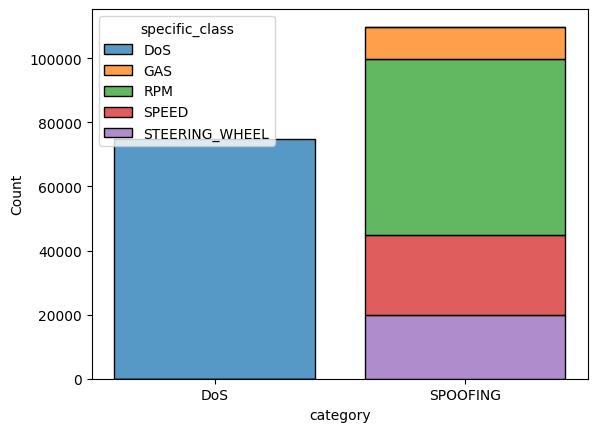

In [ ]:
value = df_attack
sns.histplot(
    data=value, x='category',
    hue='specific_class',
    multiple="stack",
    shrink=0.8
)

Create a dataframe with only the attack and one with only benign + features selection



In [ ]:
del df_attack['category']
del df_attack['specific_class']
df_attack.describe()

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
count,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000,184482.000000
mean,32.413412,14.466029,26.558358,33.168521,19.207294,10.718141,31.836781,21.506640
std,58.843930,15.714449,58.633819,51.342103,39.296997,15.287561,53.777657,32.430176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,2.000000,5.000000,0.000000,0.000000,1.000000,0.000000
50%,6.000000,11.000000,6.000000,13.000000,6.000000,5.000000,5.000000,11.000000
75%,14.000000,16.000000,13.000000,37.000000,14.000000,13.000000,14.000000,34.000000
max,194.000000,61.000000,245.000000,239.000000,168.000000,53.000000,148.000000,156.000000


In [ ]:
df_attack

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label
ID,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK
291,14,11,4,4,3,3,8,12,ATTACK
291,14,11,4,4,3,3,8,12,ATTACK
291,14,11,4,4,3,3,8,12,ATTACK
291,14,11,4,4,3,3,8,12,ATTACK
...,...,...,...,...,...,...,...,...,...
128,132,3,2,35,24,5,138,34,ATTACK
128,132,3,2,35,24,5,138,34,ATTACK
128,132,3,2,35,24,5,138,34,ATTACK


In [ ]:
df_benign = pd.read_csv('decimal/decimal_benign.csv')
del df_benign['category']
del df_benign['specific_class']
del df_benign['ID']

# Data cleaning
df_benign.dropna(inplace=True)

df_benign.describe()

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
count,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06,1.223737e+06
mean,7.691670e+01,7.835954e+01,5.930063e+01,6.111469e+01,4.921648e+01,6.038979e+01,7.776605e+01,6.611918e+01
std,9.126328e+01,9.970725e+01,7.371815e+01,9.427600e+01,6.656173e+01,9.941050e+01,1.057676e+02,1.052630e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.800000e+01,1.300000e+01,1.600000e+01,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.270000e+02,1.280000e+02,1.270000e+02,1.120000e+02,1.130000e+02,7.900000e+01,2.270000e+02,1.280000e+02
max,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


Show the correlation between data changement with benign and attack value

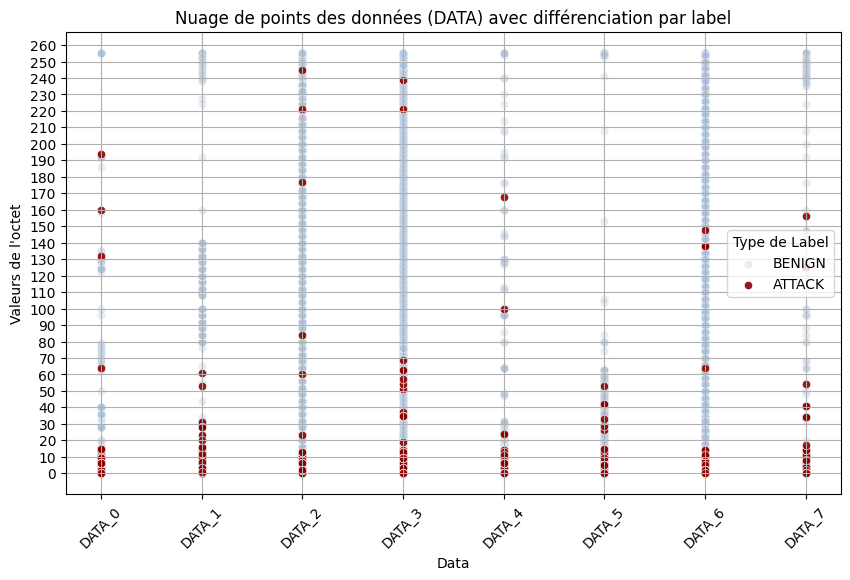

In [ ]:
df_melted = df.drop_duplicates().melt(id_vars='label', value_vars=['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7'],
                    var_name='DATA', value_name='Value')

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_melted[df_melted['label'] == 'BENIGN'],
    x='DATA',
    y='Value',
    color='lightsteelblue',
    alpha=0.3,
    label='BENIGN'
)

# + visible les attack
sns.scatterplot(
    data=df_melted[df_melted['label'] == 'ATTACK'],
    x='DATA',
    y='Value',
    color='darkred',
    alpha=0.9,
    label='ATTACK'
)

plt.yticks(np.arange(min(df_melted['Value']), max(df_melted['Value']) + 10, 10))

plt.grid()
plt.title('Nuage de points des données (DATA) avec différenciation par label')
plt.xlabel('Data')
plt.ylabel("Valeurs de l'octet")
plt.xticks(rotation=45)
plt.legend(title='Type de Label')

plt.show()

Count Plot for DATA_VALUE

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


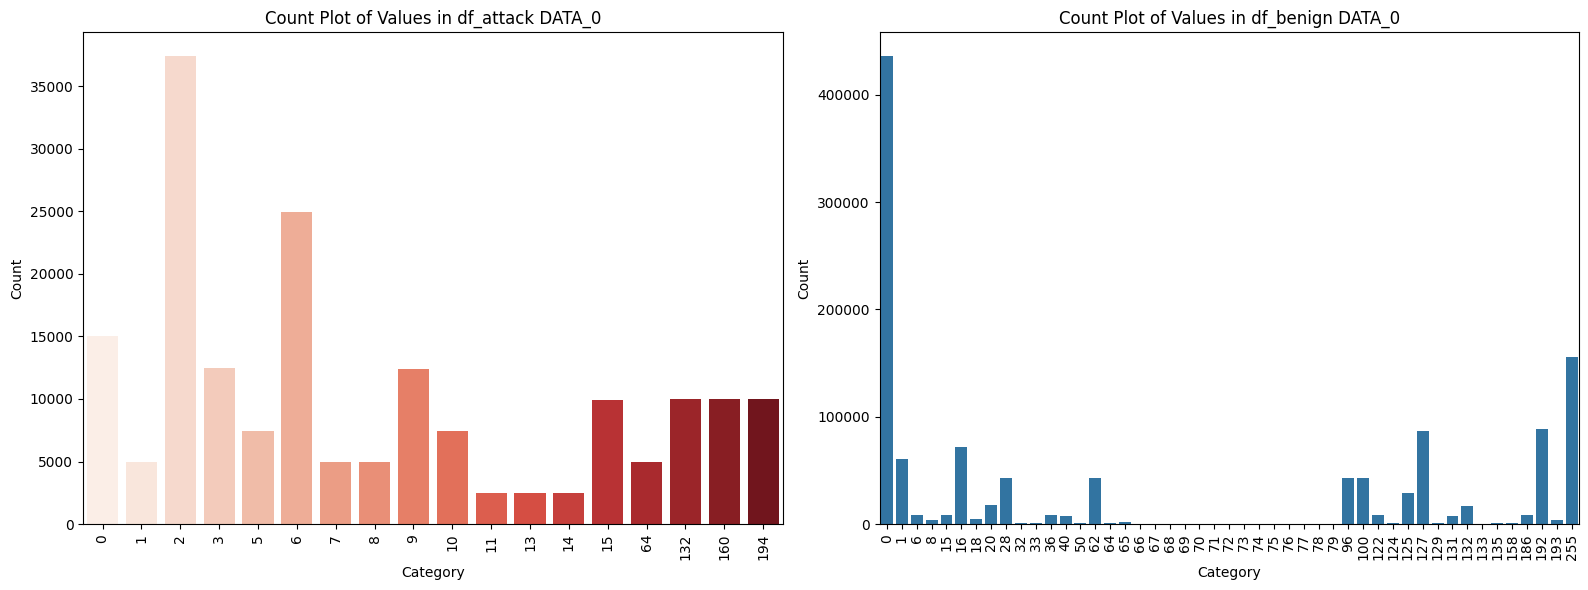

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


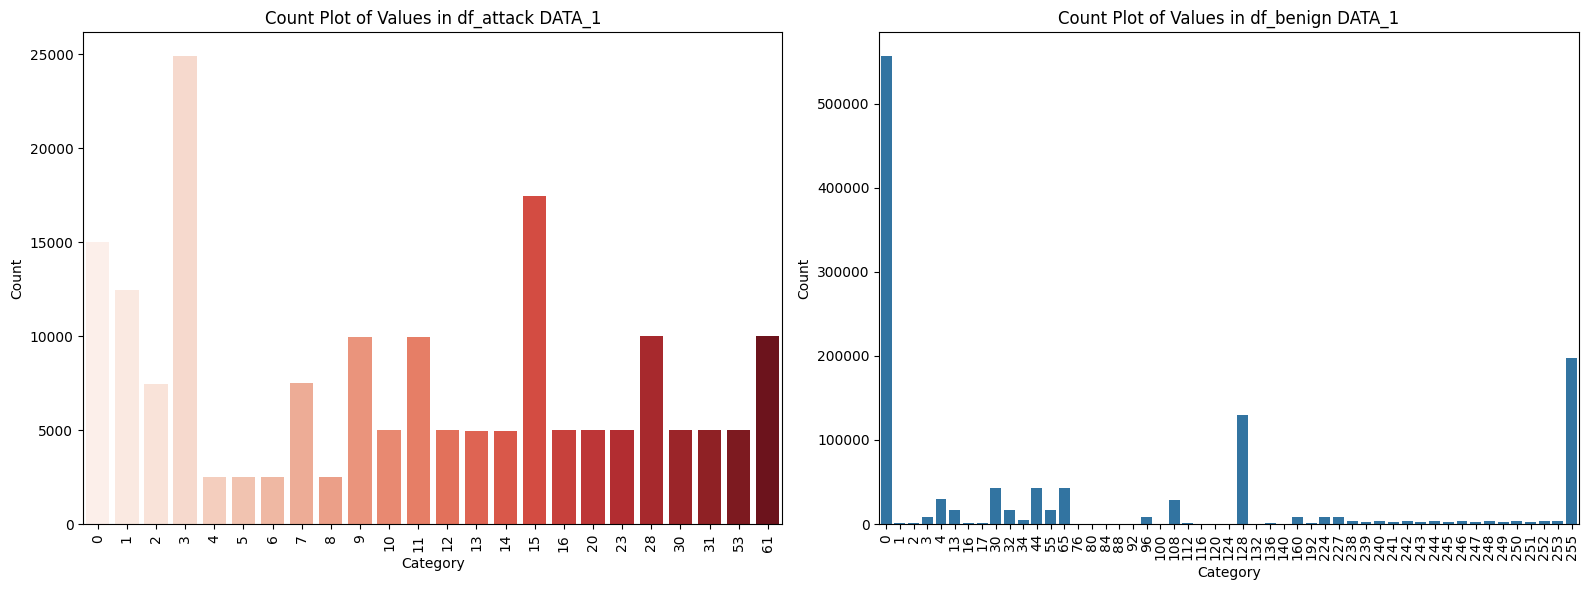

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


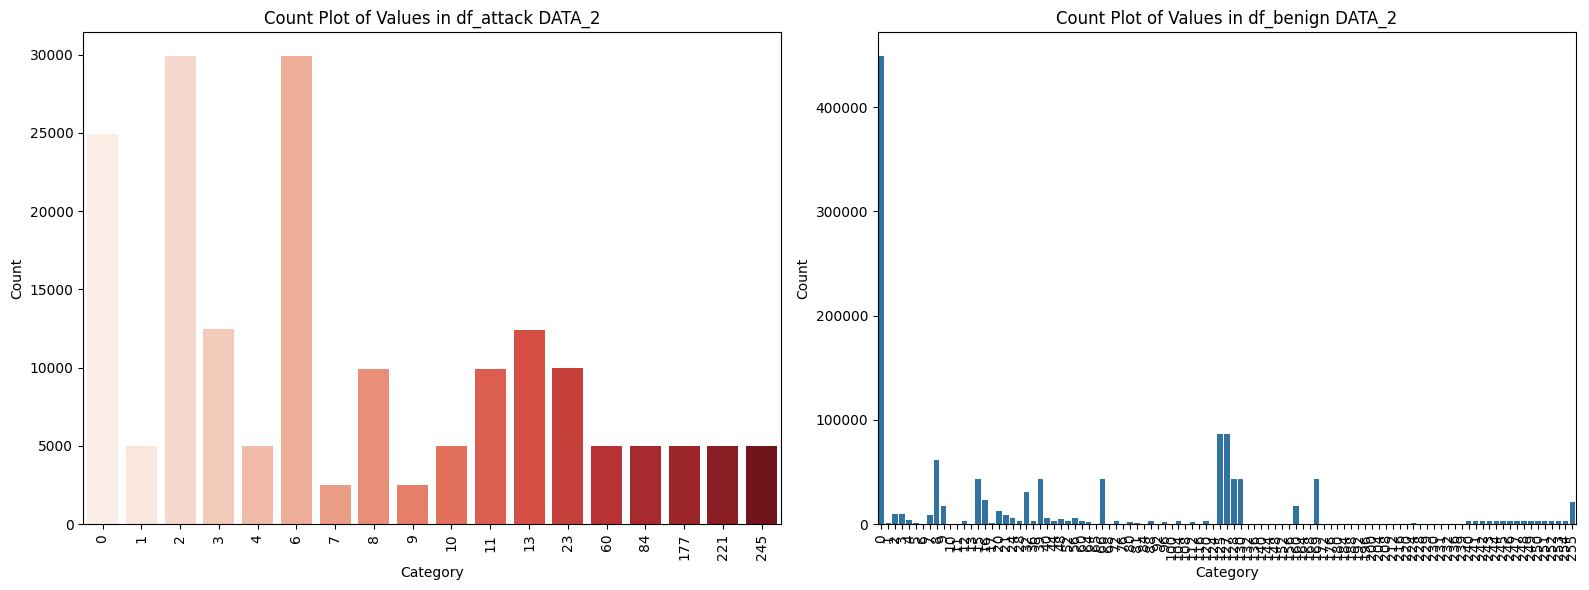

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


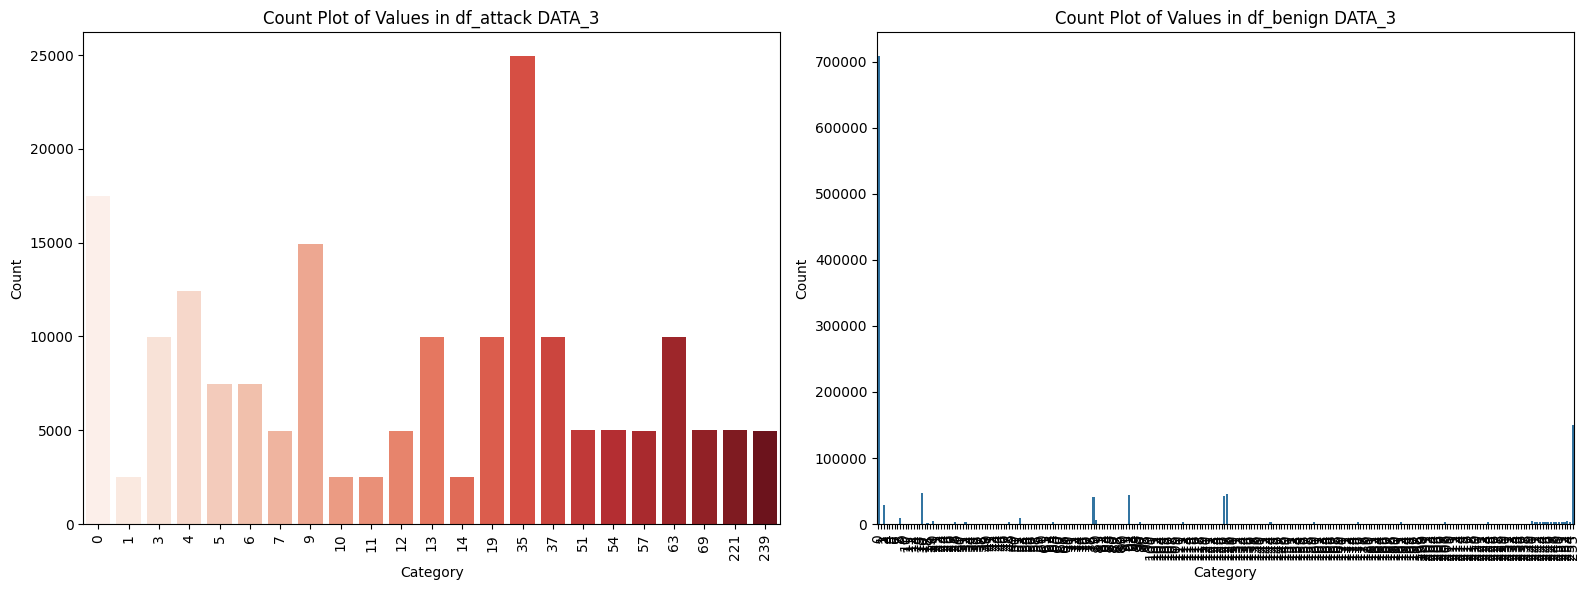

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


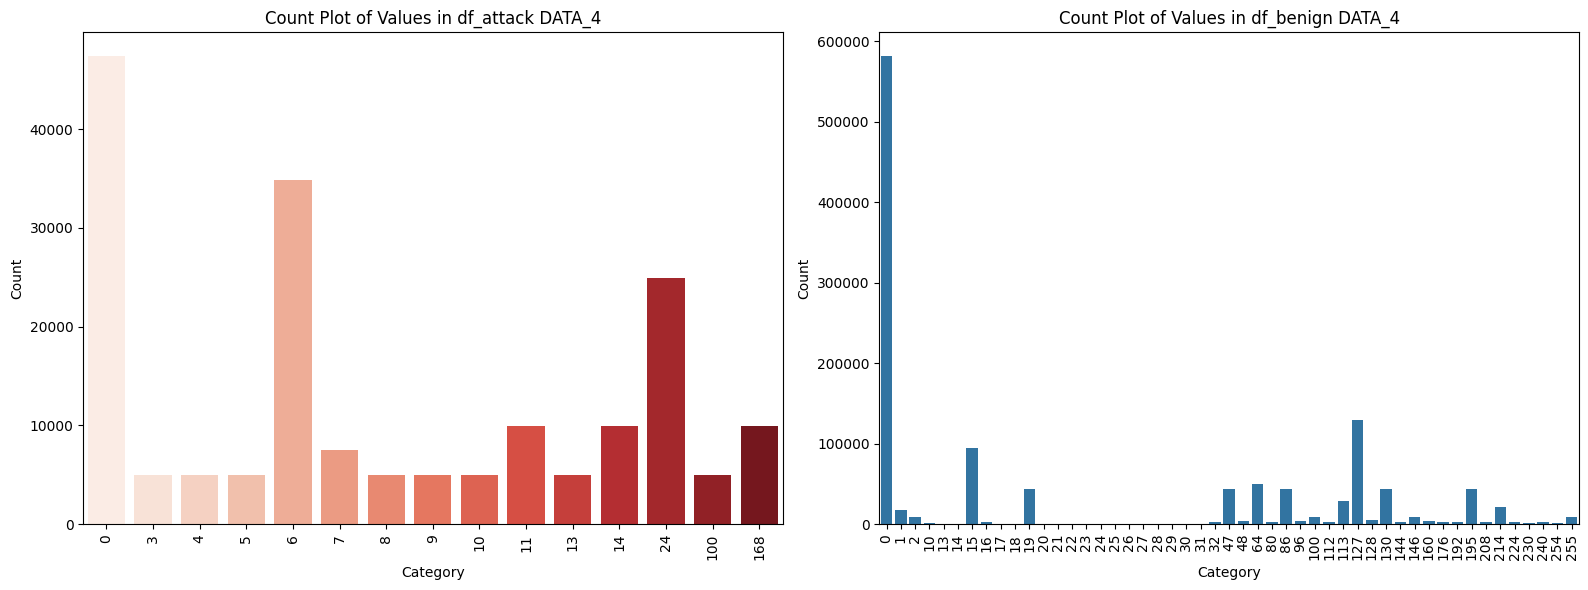

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


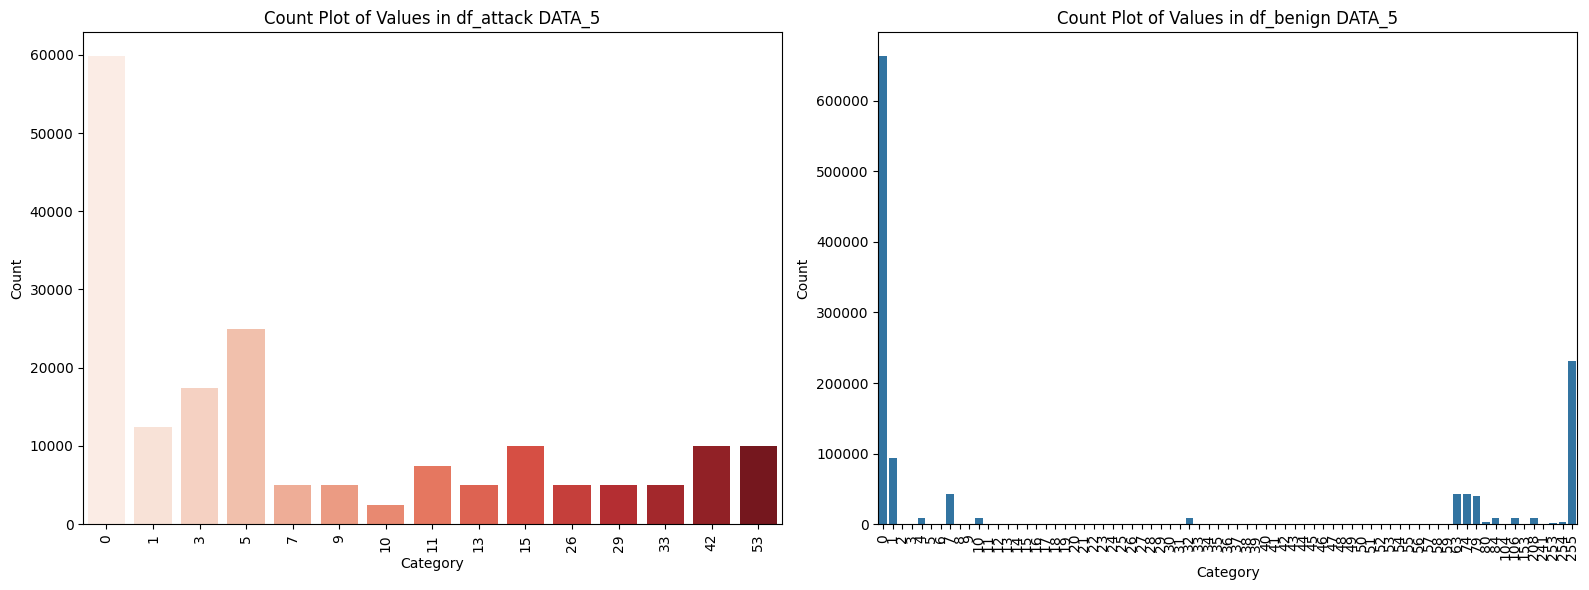

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


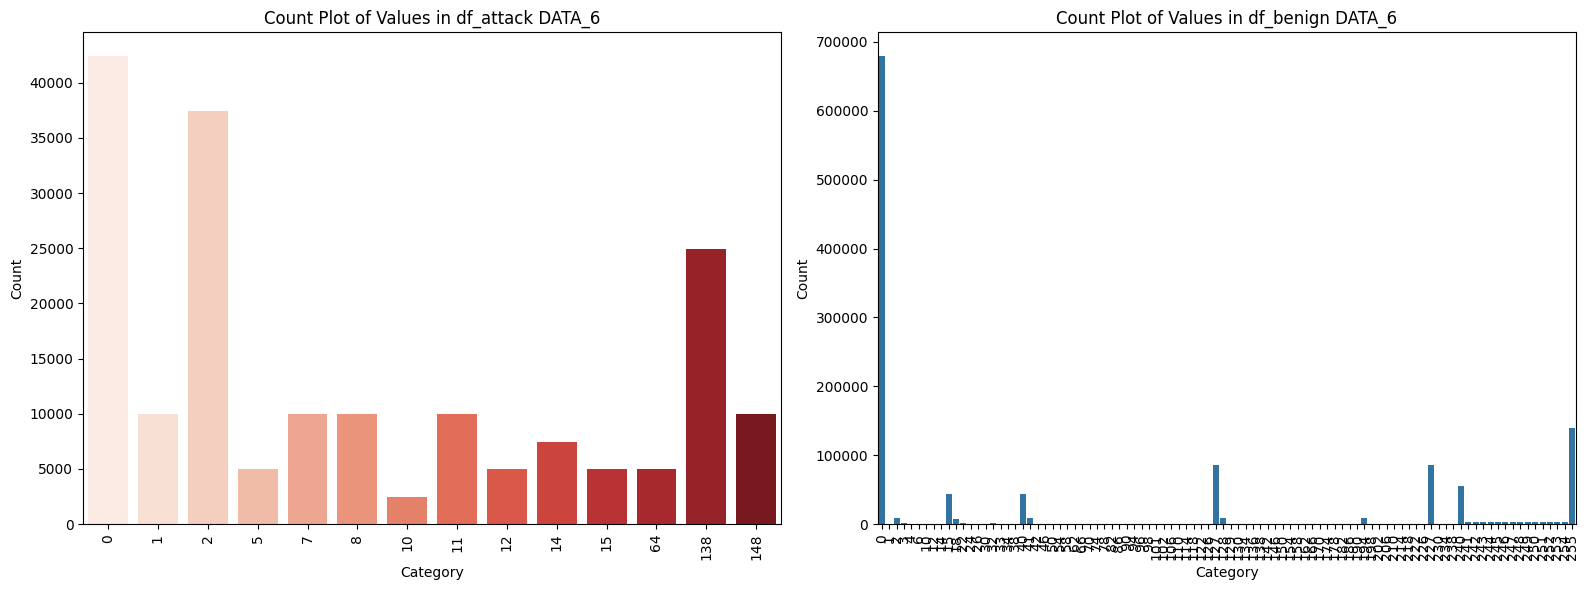

<ipython-input-15-e8a1166c35fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


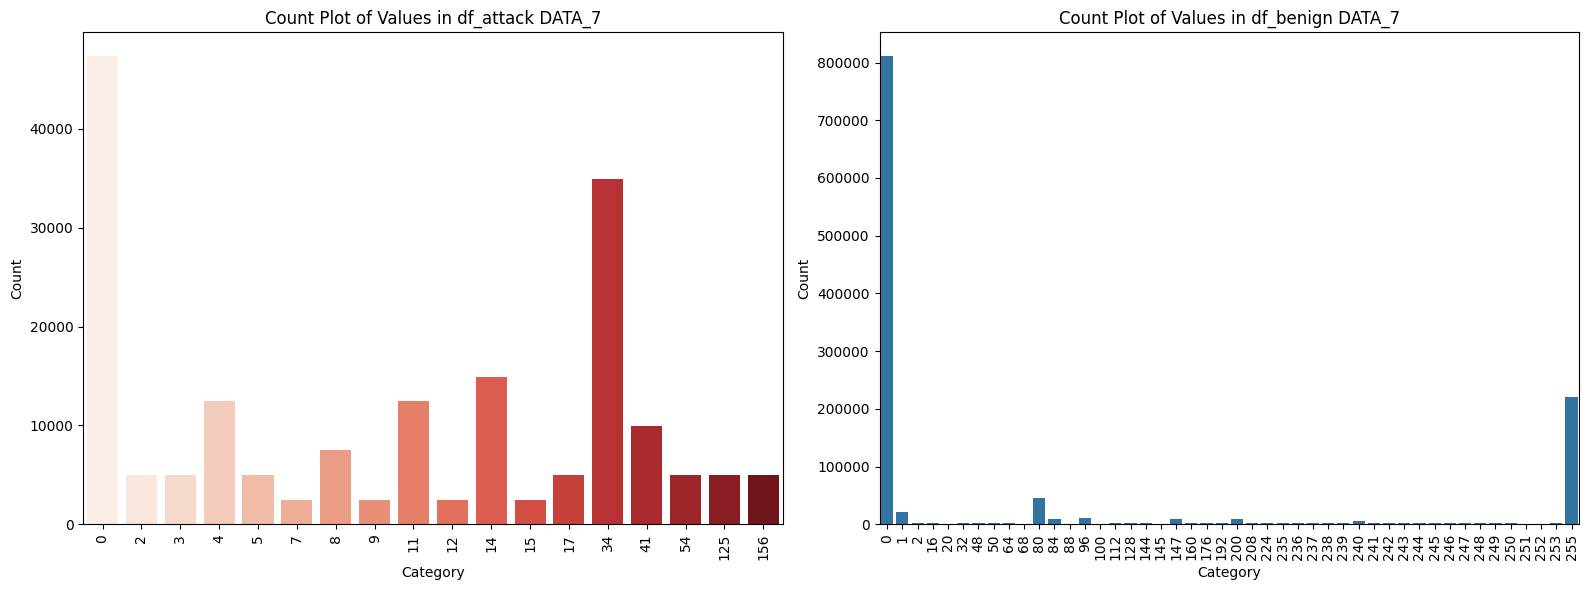

In [ ]:
val = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

for value in val:
  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  sns.countplot(
      data=df_attack,
      x=value,
      ax=axes[0],
      palette='Reds'
  )

  axes[0].set_title(f"Count Plot of Values in df_attack {value}")
  axes[0].set_xlabel("Category")
  axes[0].set_ylabel("Count")
  axes[0].tick_params(axis='x', rotation=90)

  # Plot du dataframe 'df_benign' sur le deuxième axe (à droite)
  sns.countplot(
      data=df_benign,
      x=value,
      ax=axes[1]
  )

  axes[1].set_title(f"Count Plot of Values in df_benign {value}")
  axes[1].set_xlabel("Category")
  axes[1].set_ylabel("Count")
  axes[1].tick_params(axis='x', rotation=90)

  # Afficher les plots
  plt.tight_layout()
  plt.show()

In [ ]:
def sum_data(dfs):
    cols_to_cast = dfs.columns[:-1]

    dfs[cols_to_cast] = dfs[cols_to_cast].apply(pd.to_numeric, errors='coerce')

    dfs['DATA_SUM'] = dfs[cols_to_cast].sum(axis=1)

    dfs.drop_duplicates(inplace=True)

    dfs.sort_values(by=['DATA_SUM'], inplace=True)

    return dfs



SUM all the data value to maybe get a relation

In [ ]:
df_attack_sum = sum_data(df_attack)
df_attack_sum

<ipython-input-16-b9ffccaad4d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[cols_to_cast] = dfs[cols_to_cast].apply(pd.to_numeric, errors='coerce')
<ipython-input-16-b9ffccaad4d9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['DATA_SUM'] = dfs[cols_to_cast].sum(axis=1)
<ipython-input-16-b9ffccaad4d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,DATA_SUM
ID,,,,,,,,,,
291,0,0,0,0,0,0,0,0,ATTACK,0
291,3,3,0,9,7,3,7,4,ATTACK,36
291,2,4,10,11,11,1,0,0,ATTACK,39
291,3,1,6,7,8,10,2,5,ATTACK,42
291,8,3,11,4,6,0,12,3,ATTACK,47
291,1,5,9,7,0,11,15,4,ATTACK,52
291,9,8,4,5,3,1,7,15,ATTACK,52
291,5,6,3,0,8,15,7,9,ATTACK,53
291,5,3,8,9,6,7,14,2,ATTACK,54


In [ ]:
df_benign_sum = sum_data(df_benign)
df_benign_sum

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,DATA_SUM
28,0,0,0,0,0,0,0,0,BENIGN,0
775,0,0,1,0,0,0,0,0,BENIGN,1
1135,0,0,2,0,0,0,0,0,BENIGN,2
61,0,0,3,0,0,0,0,0,BENIGN,3
8,0,0,9,0,0,0,0,0,BENIGN,9
...,...,...,...,...,...,...,...,...,...,...
427,193,1,255,255,255,255,255,255,BENIGN,1724
709,193,2,255,255,255,255,255,255,BENIGN,1725
996,193,4,255,255,255,255,255,255,BENIGN,1727
972,255,252,255,252,255,254,255,252,BENIGN,2030


In [ ]:
del df_DoS['category']
del df_DoS['specific_class']
del df_DoS['ID']

In [ ]:
df_dos_sum = sum_data(df_DoS)
df_dos_sum

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,DATA_SUM
0,0,0,0,0,0,0,0,0,ATTACK,0
44830,3,3,0,9,7,3,7,4,ATTACK,36
22451,2,4,10,11,11,1,0,0,ATTACK,39
4988,3,1,6,7,8,10,2,5,ATTACK,42
24946,8,3,11,4,6,0,12,3,ATTACK,47
2495,1,5,9,7,0,11,15,4,ATTACK,52
7480,9,8,4,5,3,1,7,15,ATTACK,52
12470,5,6,3,0,8,15,7,9,ATTACK,53
64722,5,3,8,9,6,7,14,2,ATTACK,54
29914,9,9,11,4,14,3,8,0,ATTACK,58


In [ ]:
del df_spoofing_Gas['category']
del df_spoofing_Gas['specific_class']
del df_spoofing_Gas['ID']

In [ ]:
df_spoofing_gas_sum = sum_data(df_spoofing_Gas)
df_spoofing_gas_sum

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,DATA_SUM
0,0,0,0,0,0,0,0,125,ATTACK,125
4992,0,0,0,0,0,0,64,156,ATTACK,220


In [ ]:
dataframes = [df_benign_sum, df_attack_sum]  # Liste de tes DataFrames

dataframes = [df[['label', 'DATA_SUM']] for df in dataframes]

# Concaténer les DataFrames
df_concat_sum = pd.concat(dataframes, ignore_index=True)

df_concat_sum

,label,DATA_SUM
0,BENIGN,0
1,BENIGN,1
2,BENIGN,2
3,BENIGN,3
4,BENIGN,9
...,...,...
3571,ATTACK,345
3572,ATTACK,373
3573,ATTACK,425
3574,ATTACK,433


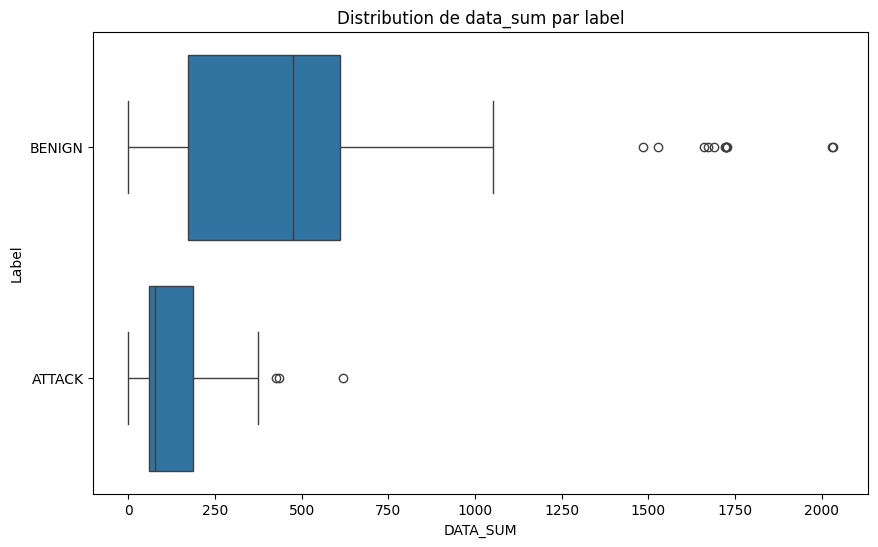

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_concat_sum,
    x='DATA_SUM',
    y='label'
)

plt.title('Distribution de data_sum par label')
plt.xlabel('DATA_SUM')
plt.ylabel('Label')
plt.show()

In [ ]:
del df_notclean['category']
del df_notclean['specific_class']

In [ ]:
df_notclean.sort_index(inplace=True)
df_notclean

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label
ID,,,,,,,,,
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...
1438,158,0,255,255,255,255,255,255,BENIGN
1438,158,0,255,255,255,255,255,255,BENIGN
1438,158,0,255,255,255,255,255,255,BENIGN


In [ ]:
df_notclean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1408219 entries, 65 to 1438
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   DATA_0  1408219 non-null  int64 
 1   DATA_1  1408219 non-null  int64 
 2   DATA_2  1408219 non-null  int64 
 3   DATA_3  1408219 non-null  int64 
 4   DATA_4  1408219 non-null  int64 
 5   DATA_5  1408219 non-null  int64 
 6   DATA_6  1408219 non-null  int64 
 7   DATA_7  1408219 non-null  int64 
 8   label   1408219 non-null  object
dtypes: int64(8), object(1)
memory usage: 107.4+ MB


It was a graphic that show the value depending on the time while using ID for this, but it wasn't the good meaning of the ID category

In [ ]:
# bit_rate = 1000000  # 1Mbit/s
# bits_per_row = 8
# df_notclean['time_seconds'] = df_notclean.index * bits_per_row / bit_rate

# columns_to_plot = ['DATA_0']

# plt.figure(figsize=(12, 6))
# for label in df_notclean['label'].unique(): # Select ATTACK and BENIGN
#     subset = df_notclean[df_notclean['label'] == label] # Subplot BENIGN AND ATTACK
#     for col in columns_to_plot:
#         plt.plot(subset['time_seconds'], subset[col], label=f"{label} - {col}")


# plt.xlabel('Time (seconds)')
# plt.ylabel('Data Values')
# plt.title(f"Data Values over Time by Label ({bit_rate} bit/s)")
# plt.legend(title='Label and Data Column')
# plt.grid()
# plt.show()


# columns_to_plot = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

# subset_attack = df_notclean[df_notclean['label'] == 'ATTACK']
# for col in columns_to_plot:
#   plt.plot(subset['time_seconds'], subset_attack[col], label=f"{label} - {col}")

# plt.xlabel('Time (seconds)')
# plt.ylabel('Data Values')
# plt.title(f"Data Values over Time by Label ({bit_rate} bit/s)")
# plt.legend(title='Label and Data Column')
# plt.grid()
# plt.show()

In [ ]:
df_Benign[df_Benign['ID'] == 531]

,ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
15,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
38,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
66,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
100,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
124,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...
1223623,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
1223647,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
1223682,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN
1223707,531,255,255,8,127,47,7,255,80,BENIGN,BENIGN,BENIGN


In [ ]:
df_notclean

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label
ID,,,,,,,,,
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
65,96,0,0,0,0,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...
1438,158,0,255,255,255,255,255,255,BENIGN
1438,158,0,255,255,255,255,255,255,BENIGN
1438,158,0,255,255,255,255,255,255,BENIGN


In [ ]:
df_notclean.value_counts()

DATA_0  DATA_1  DATA_2  DATA_3  DATA_4  DATA_5  DATA_6  DATA_7  label 
127     255     127     255     127     255     127     255     BENIGN    86385
192     0       125     0       0       0       0       0       BENIGN    86383
0       128     0       0       0       1       227     0       BENIGN    86383
255     255     15      255     127     255     255     255     BENIGN    43194
                8       127     47      7       255     80      BENIGN    43194
                                                                          ...  
0       112     68      248     96      32      32      0       BENIGN        1
                72      248     96      32      32      0       BENIGN        1
                76      248     96      32      32      0       BENIGN        1
                80      248     96      32      32      0       BENIGN        1
        140     164     248     96      32      32      0       BENIGN        1
Name: count, Length: 3576, dtype: int64

In [ ]:
df_Benign.min()

,0
ID,65
DATA_0,0
DATA_1,0
DATA_2,0
DATA_3,0
DATA_4,0
DATA_5,0
DATA_6,0
DATA_7,0
label,BENIGN


In [ ]:
df_attack
del df_attack['DATA_SUM']
del df_attack['label']

In [ ]:
df_attack

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
ID,,,,,,,,
291,0,0,0,0,0,0,0,0
291,3,3,0,9,7,3,7,4
291,2,4,10,11,11,1,0,0
291,3,1,6,7,8,10,2,5
291,8,3,11,4,6,0,12,3
291,1,5,9,7,0,11,15,4
291,9,8,4,5,3,1,7,15
291,5,6,3,0,8,15,7,9
291,5,3,8,9,6,7,14,2


In [ ]:
df_Benign
del df_Benign['specific_class']
del df_Benign['category']
del df_Benign['label']
del df_Benign['ID']

In [ ]:
df_Benign

,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7
0,96,0,0,0,0,0,0,0
1,132,13,160,0,0,0,0,0
2,127,255,127,255,127,255,127,255
3,15,224,0,0,0,0,0,0
4,1,0,39,16,0,0,0,0
...,...,...,...,...,...,...,...,...
1223732,255,255,15,255,127,255,255,255
1223733,0,0,249,96,0,63,255,255
1223734,255,255,8,127,47,7,255,80
1223735,0,0,0,0,0,0,249,96


## Machine learning

### Classification binaire : Attaque ou pas attaque ?

Après recherches, nous avons determiné que l'algorythme RandomForest pouvait être efficient pour une détection binaire (attaque ou non) en utilisant les données décimales.

- 0 signifie un cas bénin
- 1 représente une attaque quel que soit son type

Pour la classification plus poussée (DoS/Spoofing, etc...) sur les données Décimales, nous

### Algorythme de Classification binaire | RandomForest

<ipython-input-37-c271a7d58026>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attack['isMechant'] = 1


Accuracy: 99.9992%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    244747
           1       1.00      0.75      0.86         8

    accuracy                           1.00    244755
   macro avg       1.00      0.88      0.93    244755
weighted avg       1.00      1.00      1.00    244755



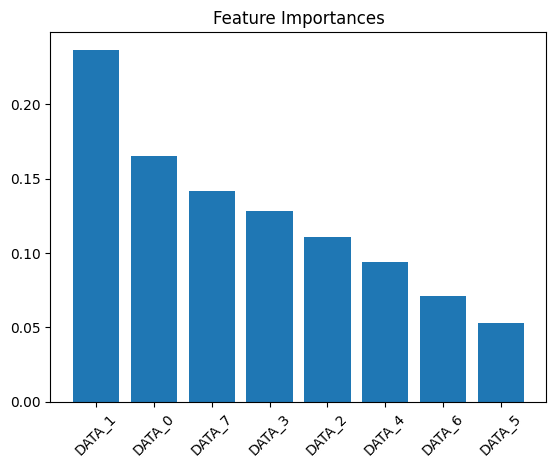

Y'a eu erreur ici :
    DATA_0  DATA_1  DATA_2  DATA_3  DATA_4  DATA_5  DATA_6  DATA_7
24       0       0       0       0       0       0       0     125
22       0       0       0       0     100       0       2       0


In [ ]:


# Import des dataframes
# df_DoS = pd.read_csv('./decimal/decimal_DoS.csv')
# df_spoofing_Gas = pd.read_csv('./decimal/decimal_spoofing-GAS.csv')
# df_spoofing_RPM = pd.read_csv('./decimal/decimal_spoofing-RPM.csv')
# df_spoofing_speed = pd.read_csv('./decimal/decimal_spoofing-SPEED.csv')
# df_spoofing_steering = pd.read_csv('./decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_benign = pd.read_csv('./decimal/decimal_benign.csv')
# df_atk = pd.concat([df_DoS, df_spoofing_Gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)

# Feature selection
df_attack['isMechant'] = 1
df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)

# On crée nos colonnes X et Y
X = df_combined.drop(columns=['isMechant'])
y = df_combined['isMechant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# print(X_train, y_train)

# Paramètres du modèle RandomForest

modeleu = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Prédictions sur les nouvelles données
modeleu.fit(X_train, y_train)
y_pred = modeleu.predict(X_test)

# Rapport de perf
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100,4)}%")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# print(cm)

# Importance des features
importances = modeleu.feature_importances_
feature_names = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.show()

# Donées mal classées ~ On regarde ou le test et la prédiction ne correspondaient pas
misclassified = X_test[y_test != y_pred]
print("Y'a eu erreur ici :")
print(misclassified)

On peut donc voir que les prédictions ont une précision proche de 100%  (les cas d'erreurs étant dus à des données avec une valeur de 0).
On peut donc affirmer qu'un pattern permet de distinguer les attaques des cas bénins.

Ces prédictions nous ont également permis de déterminer l'importance des données dans la détection et de voir que c'est principalement DATA_3 et DATA_1 qui jouent sur la détection.

In [ ]:
df_spoofing

,ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
0,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
1,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
2,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
3,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
4,513,0,0,0,0,0,0,0,125,ATTACK,SPOOFING,GAS
...,...,...,...,...,...,...,...,...,...,...,...,...
19972,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19973,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19974,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
19975,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


<Axes: xlabel='specific_class', ylabel='Count'>

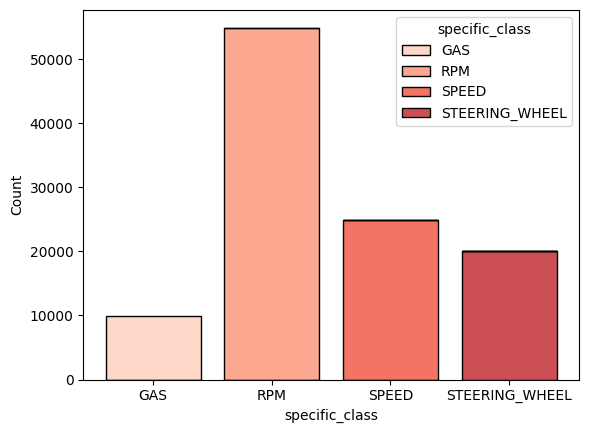

In [ ]:
sns.histplot(
    data=df_spoofing,
    x='specific_class',
    hue='specific_class',
    multiple="stack",
    shrink=0.8,
    palette='Reds'
)

# RandomForest test importance spoofing specific_class submodel

In [ ]:
importances_list = []


Accuracy: 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19966
           1       1.00      1.00      1.00      1998

    accuracy                           1.00     21964
   macro avg       1.00      1.00      1.00     21964
weighted avg       1.00      1.00      1.00     21964



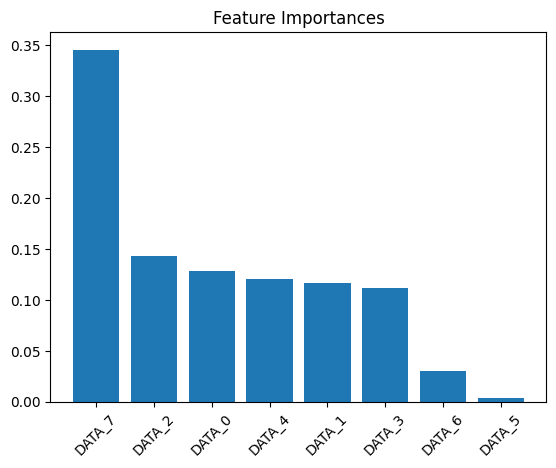

Y'a eu erreur ici :
Empty DataFrame
Columns: [DATA_0, DATA_1, DATA_2, DATA_3, DATA_4, DATA_5, DATA_6, DATA_7]
Index: []


In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isGas'] = 1
df_spoofing_RPM['isGas'] = 0
df_spoofing_speed['isGas'] = 0
df_spoofing_steering['isGas'] = 0
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isGas'])
y = df_combined['isGas']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# print(X_train, y_train)

# Paramètres du modèle RandomForest

modeleu = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Prédictions sur les nouvelles données
modeleu.fit(X_train, y_train)
y_pred = modeleu.predict(X_test)

# Rapport de perf
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100,4)}%")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# print(cm)

# Importance des features
importances = modeleu.feature_importances_
feature_names = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

indices = np.argsort(importances)[::-1]

importances_tuples = [(feature_names[i], importances[i]) for i in range(len(feature_names))]
importances_list.append(importances_tuples)

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.show()

# Donées mal classées ~ On regarde ou le test et la prédiction ne correspondaient pas
misclassified = X_test[y_test != y_pred]
print("Y'a eu erreur ici :")
print(misclassified)

Accuracy: 95.3333%
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     10984
           1       0.91      1.00      0.96     10980

    accuracy                           0.95     21964
   macro avg       0.96      0.95      0.95     21964
weighted avg       0.96      0.95      0.95     21964



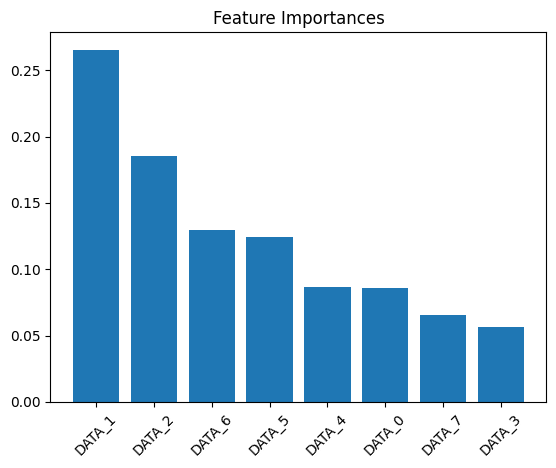

Y'a eu erreur ici :
       DATA_0  DATA_1  DATA_2  DATA_3  DATA_4  DATA_5  DATA_6  DATA_7
83590       6      28       6      63       6      42       2      41
83344       6      28       6      63       6      42       2      41
81956       6      28       6      63       6      42       2      41
83120       6      28       6      63       6      42       2      41
82039       6      28       6      63       6      42       2      41
...       ...     ...     ...     ...     ...     ...     ...     ...
83634       6      28       6      63       6      42       2      41
84281       6      28       6      63       6      42       2      41
82921       6      28       6      63       6      42       2      41
80187       6      28       6      63       6      42       2      41
84138       6      28       6      63       6      42       2      41

[1025 rows x 8 columns]


In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isRpm'] = 0
df_spoofing_RPM['isRpm'] = 1
df_spoofing_speed['isRpm'] = 0
df_spoofing_steering['isRpm'] = 0
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isRpm'])
y = df_combined['isRpm']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# print(X_train, y_train)

# Paramètres du modèle RandomForest

modeleu = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Prédictions sur les nouvelles données
modeleu.fit(X_train, y_train)
y_pred = modeleu.predict(X_test)

# Rapport de perf
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100,4)}%")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# print(cm)

# Importance des features
importances = modeleu.feature_importances_
feature_names = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

importances_tuples = [(feature_names[i], importances[i]) for i in range(len(feature_names))]
importances_list.append(importances_tuples)

indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.show()

# Donées mal classées ~ On regarde ou le test et la prédiction ne correspondaient pas
misclassified = X_test[y_test != y_pred]
print("Y'a eu erreur ici :")
print(misclassified)

Accuracy: 95.2422%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16974
           1       1.00      0.79      0.88      4990

    accuracy                           0.95     21964
   macro avg       0.97      0.90      0.93     21964
weighted avg       0.96      0.95      0.95     21964



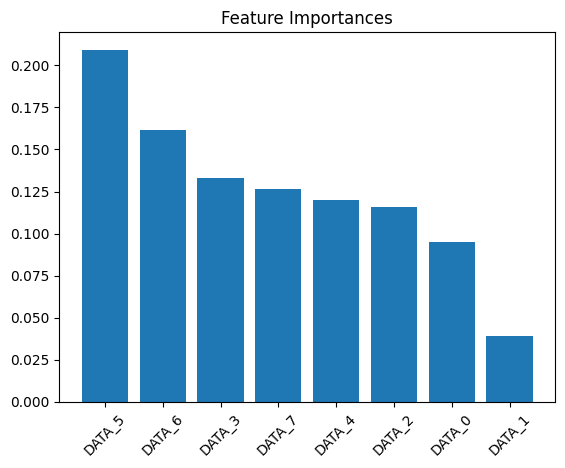

Y'a eu erreur ici :
       DATA_0  DATA_1  DATA_2  DATA_3  DATA_4  DATA_5  DATA_6  DATA_7
82569       6      28       6      63       6      42       2      41
79997       6      28       6      63       6      42       2      41
83016       6      28       6      63       6      42       2      41
81876       6      28       6      63       6      42       2      41
81511       6      28       6      63       6      42       2      41
...       ...     ...     ...     ...     ...     ...     ...     ...
80606       6      28       6      63       6      42       2      41
80844       6      28       6      63       6      42       2      41
81755       6      28       6      63       6      42       2      41
83985       6      28       6      63       6      42       2      41
83639       6      28       6      63       6      42       2      41

[1045 rows x 8 columns]


In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isSpeed'] = 0
df_spoofing_RPM['isSpeed'] = 0
df_spoofing_speed['isSpeed'] = 1
df_spoofing_steering['isSpeed'] = 0
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isSpeed'])
y = df_combined['isSpeed']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# print(X_train, y_train)

# Paramètres du modèle RandomForest

modeleu = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Prédictions sur les nouvelles données
modeleu.fit(X_train, y_train)
y_pred = modeleu.predict(X_test)

# Rapport de perf
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100,4)}%")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# print(cm)

# Importance des features
importances = modeleu.feature_importances_
feature_names = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

importances_tuples = [(feature_names[i], importances[i]) for i in range(len(feature_names))]
importances_list.append(importances_tuples)


indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.show()

# Donées mal classées ~ On regarde ou le test et la prédiction ne correspondaient pas
misclassified = X_test[y_test != y_pred]
print("Y'a eu erreur ici :")
print(misclassified)

Accuracy: 99.9954%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17969
           1       1.00      1.00      1.00      3995

    accuracy                           1.00     21964
   macro avg       1.00      1.00      1.00     21964
weighted avg       1.00      1.00      1.00     21964



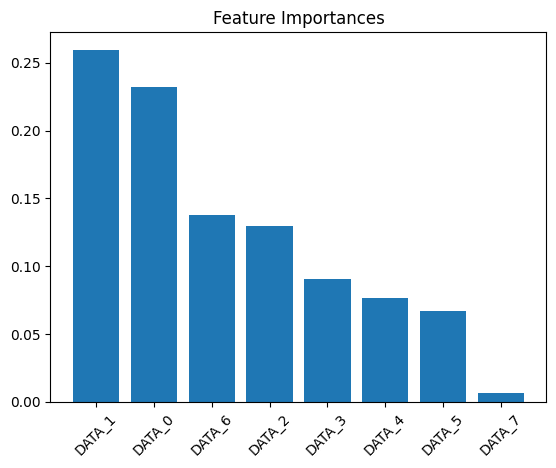

Y'a eu erreur ici :
       DATA_0  DATA_1  DATA_2  DATA_3  DATA_4  DATA_5  DATA_6  DATA_7
59900       0       0       0       0       0       0       0       0


In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isSteering'] = 0
df_spoofing_RPM['isSteering'] = 0
df_spoofing_speed['isSteering'] = 0
df_spoofing_steering['isSteering'] = 1
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isSteering'])
y = df_combined['isSteering']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# print(X_train, y_train)

# Paramètres du modèle RandomForest

modeleu = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Prédictions sur les nouvelles données
modeleu.fit(X_train, y_train)
y_pred = modeleu.predict(X_test)

# Rapport de perf
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100,4)}%")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# print(cm)

# Importance des features
importances = modeleu.feature_importances_
feature_names = ['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']

importances_tuples = [(feature_names[i], importances[i]) for i in range(len(feature_names))]
importances_list.append(importances_tuples)

indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.show()

# Donées mal classées ~ On regarde ou le test et la prédiction ne correspondaient pas
misclassified = X_test[y_test != y_pred]
print("Y'a eu erreur ici :")
print(misclassified)

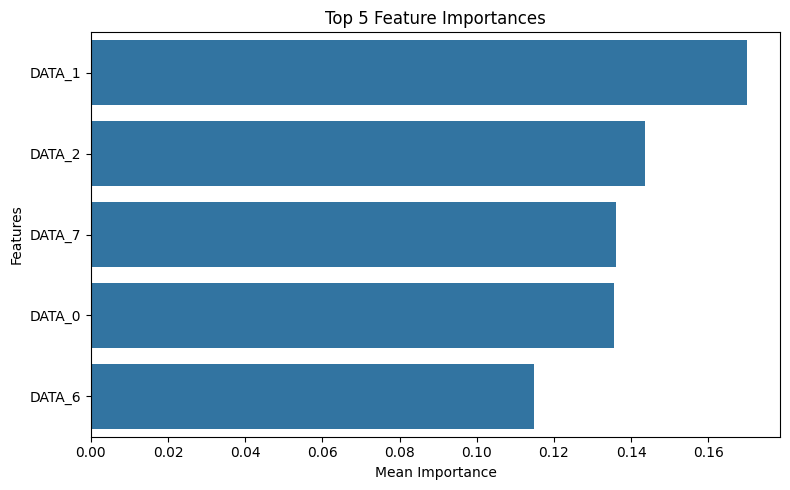

In [ ]:
df_importances = pd.DataFrame(
    [{feature: imp for feature, imp in imp_list} for imp_list in importances_list]
)

# Calculer la moyenne pour chaque feature
mean_importances = df_importances.mean()

# Trier les moyennes par importance décroissante et garder les 5 plus importantes
top_5_importances = mean_importances.nlargest(5)

# Affichage des 5 plus grandes importances avec Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x=top_5_importances.values, y=top_5_importances.index, orient='h')
plt.title("Top 5 Feature Importances")
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 15982, number of negative: 71873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 87855, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181913 -> initscore=-1.503438
[LightGBM] [Info] Start training from score -1.503438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

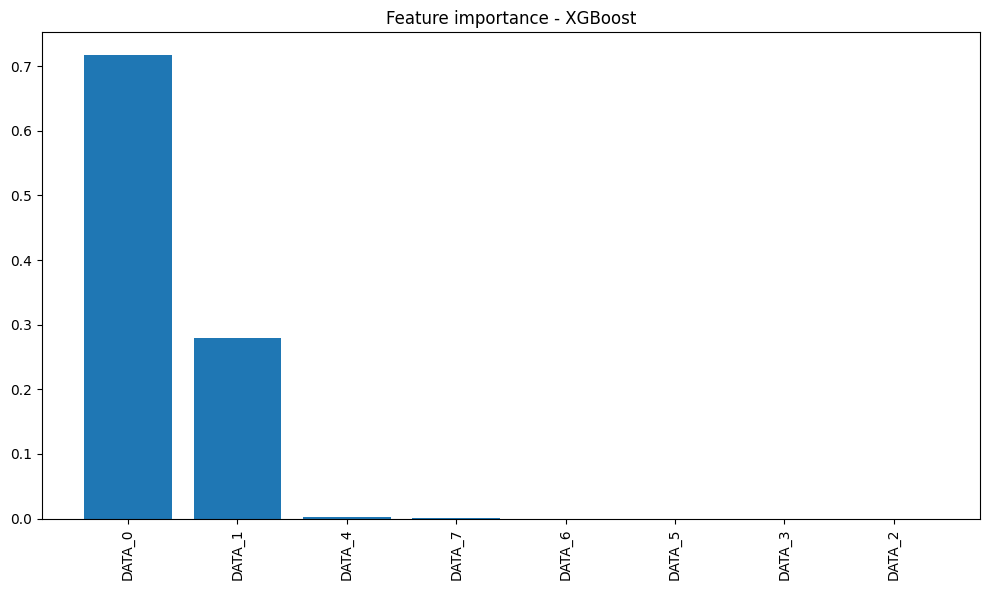

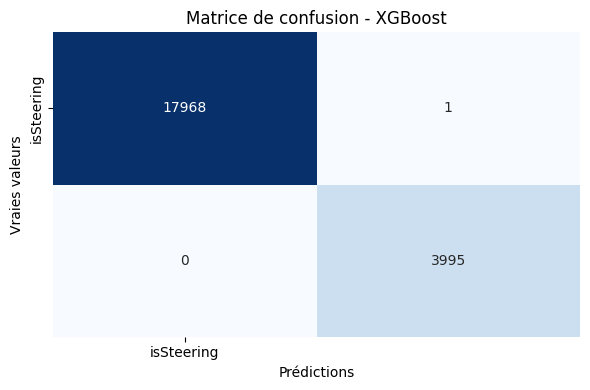

--- LightGBM ---
Accuracy: 1.0000
ROC AUC Score: 0.9999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17969
           1       1.00      1.00      1.00      3995

    accuracy                           1.00     21964
   macro avg       1.00      1.00      1.00     21964
weighted avg       1.00      1.00      1.00     21964





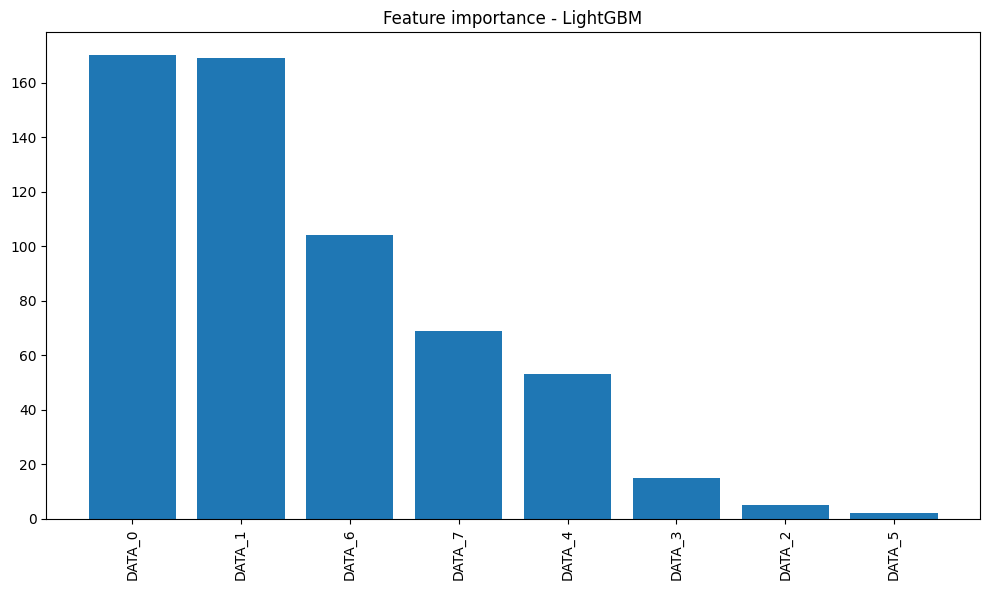

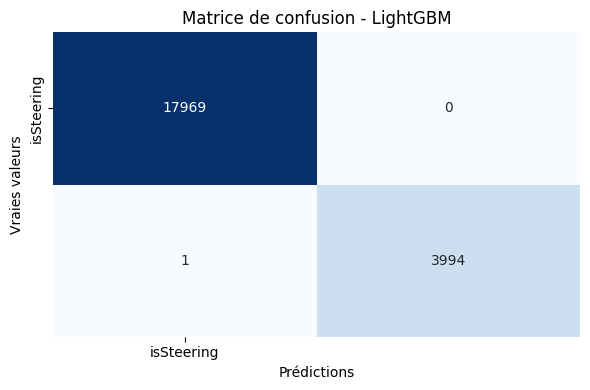

--- ExtraTrees ---
Accuracy: 1.0000
ROC AUC Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17969
           1       1.00      1.00      1.00      3995

    accuracy                           1.00     21964
   macro avg       1.00      1.00      1.00     21964
weighted avg       1.00      1.00      1.00     21964





In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isSteering'] = 0
df_spoofing_RPM['isSteering'] = 0
df_spoofing_speed['isSteering'] = 0
df_spoofing_steering['isSteering'] = 1
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isSteering'])
y = df_combined['isSteering']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



# xgboots
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# lightgbm
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# XtraTrees
extra_tree_model = ExtraTreesClassifier()
extra_tree_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['0', '1']))
    print("\n")

def plot_feature_importance(model, model_name, feature_names):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importance - {model_name}")
    plt.bar(range(len(importance)), importance[indices], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['isSteering'],
                yticklabels=['isSteering'])
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.tight_layout()
    plt.show()

evaluate_model(xgb_model, X_test, y_test, "XGBoost")
plot_feature_importance(xgb_model, "XGBoost", X.columns)
plot_confusion_matrix(xgb_model, X_test, y_test, "XGBoost")

evaluate_model(lgbm_model, X_test, y_test, "LightGBM")
plot_feature_importance(lgbm_model, "LightGBM", X.columns)
plot_confusion_matrix(lgbm_model, X_test, y_test, "LightGBM")

evaluate_model(extra_tree_model, X_test, y_test, "ExtraTrees")
plot_feature_importance(extra_tree_model, "ExtraTrees", X.columns)
plot_confusion_matrix(extra_tree_model, X_test, y_test, "EtraTrees")

In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isGas'] = 1
df_spoofing_RPM['isGas'] = 0
df_spoofing_speed['isGas'] = 0
df_spoofing_steering['isGas'] = 0
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isGas'])
y = df_combined['isGas']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



# xgboots
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# lightgbm
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# XtraTrees
extra_tree_model = ExtraTreesClassifier()
extra_tree_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['0', '1']))
    print("\n")

def plot_feature_importance(model, model_name, feature_names):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importance - {model_name}")
    plt.bar(range(len(importance)), importance[indices], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['isSteering'],
                yticklabels=['isSteering'])
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.tight_layout()
    plt.show()

evaluate_model(xgb_model, X_test, y_test, "XGBoost")
plot_feature_importance(xgb_model, "XGBoost", X.columns)
plot_confusion_matrix(xgb_model, X_test, y_test, "XGBoost")

evaluate_model(lgbm_model, X_test, y_test, "LightGBM")
plot_feature_importance(lgbm_model, "LightGBM", X.columns)
plot_confusion_matrix(lgbm_model, X_test, y_test, "LightGBM")

evaluate_model(extra_tree_model, X_test, y_test, "ExtraTrees")
plot_feature_importance(extra_tree_model, "ExtraTrees", X.columns)
plot_confusion_matrix(extra_tree_model, X_test, y_test, "EtraTrees")

In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isRpm'] = 0
df_spoofing_RPM['isRpm'] = 1
df_spoofing_speed['isRpm'] = 0
df_spoofing_steering['isRpm'] = 0
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isRpm'])
y = df_combined['isRpm']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



# xgboots
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# lightgbm
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# XtraTrees
extra_tree_model = ExtraTreesClassifier()
extra_tree_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['0', '1']))
    print("\n")

def plot_feature_importance(model, model_name, feature_names):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importance - {model_name}")
    plt.bar(range(len(importance)), importance[indices], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['isSteering'],
                yticklabels=['isSteering'])
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.tight_layout()
    plt.show()

evaluate_model(xgb_model, X_test, y_test, "XGBoost")
plot_feature_importance(xgb_model, "XGBoost", X.columns)
plot_confusion_matrix(xgb_model, X_test, y_test, "XGBoost")

evaluate_model(lgbm_model, X_test, y_test, "LightGBM")
plot_feature_importance(lgbm_model, "LightGBM", X.columns)
plot_confusion_matrix(lgbm_model, X_test, y_test, "LightGBM")

evaluate_model(extra_tree_model, X_test, y_test, "ExtraTrees")
plot_feature_importance(extra_tree_model, "ExtraTrees", X.columns)
plot_confusion_matrix(extra_tree_model, X_test, y_test, "EtraTrees")

In [ ]:
df_spoofing_gas = pd.read_csv('decimal/decimal_spoofing-GAS.csv')
df_spoofing_RPM = pd.read_csv('decimal/decimal_spoofing-RPM.csv')
df_spoofing_speed = pd.read_csv('decimal/decimal_spoofing-SPEED.csv')
df_spoofing_steering = pd.read_csv('decimal/decimal_spoofing-STEERING_WHEEL.csv')

# df_attack['isMechant'] = 1
# df_Benign['isMechant'] = 0

# On combine le tout et on enlève les colonnes inutiles
# df_combined = pd.concat([df_attack, df_Benign], ignore_index=True)
# df_combined = df_combined.drop(columns=['ID','label','specific_class', 'category'])

# print(df_combined)
df_spoofing_gas['isSpeed'] = 0
df_spoofing_RPM['isSpeed'] = 0
df_spoofing_speed['isSpeed'] = 1
df_spoofing_steering['isSpeed'] = 0
# On crée nos colonnes X et Y
df_combined = pd.concat([df_spoofing_gas, df_spoofing_RPM, df_spoofing_speed, df_spoofing_steering], ignore_index=True)
df_combined = df_combined.drop(columns=['ID', 'label','specific_class', 'category'])
X = df_combined.drop(columns=['isSpeed'])
y = df_combined['isSpeed']

df_combined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



# xgboots
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# lightgbm
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# XtraTrees
extra_tree_model = ExtraTreesClassifier()
extra_tree_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['0', '1']))
    print("\n")

def plot_feature_importance(model, model_name, feature_names):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importance - {model_name}")
    plt.bar(range(len(importance)), importance[indices], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['isSteering'],
                yticklabels=['isSteering'])
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.tight_layout()
    plt.show()

evaluate_model(xgb_model, X_test, y_test, "XGBoost")
plot_feature_importance(xgb_model, "XGBoost", X.columns)
plot_confusion_matrix(xgb_model, X_test, y_test, "XGBoost")

evaluate_model(lgbm_model, X_test, y_test, "LightGBM")
plot_feature_importance(lgbm_model, "LightGBM", X.columns)
plot_confusion_matrix(lgbm_model, X_test, y_test, "LightGBM")

evaluate_model(extra_tree_model, X_test, y_test, "ExtraTrees")
plot_feature_importance(extra_tree_model, "ExtraTrees", X.columns)
plot_confusion_matrix(extra_tree_model, X_test, y_test, "EtraTrees")